# Textklassifikation mit RNN: GermEval 2018

*GermEval* – für German Evaluation – ist ein jährlicher Wettbewerb im Bereich Natural Language Processing für deutschsprachige Texte (s. [https://germeval.github.io/](https://germeval.github.io/)).

Im Jahr 2018 ging es um die Erkennung von Beleidigungen in deutschsprachigen Tweets.

In dieser Aufgabe wollen wir Rekurrente Neuronale Netze (RNN) zur Klassifikation nutzen. Zunächst einmal starten wir mit Vorarbeiten.

In [1]:
from collections import namedtuple # for reading data
from collections import Counter    # for counting number of occurance in the data
import matplotlib.pyplot as plt    # for visualisations

## Format der Daten

Die Trainings- und Testdaten liegen als mit Tabulatoren separierte Textdateien (Tab Separated Values – TSV) vor. Uns interessieren die erste Spalte (der Tweet) und die zweite Spalte (`OFFENSE` für Beleidigung bzw. `OTHER` für keine Beleidigung).

Der Befehl [`head`](https://wiki.ubuntuusers.de/head/) zeigt uns die ersten zeilen einer (Text-) Datei an, um folgenden Code Beispiel die ersten 10 Zeilen der Datei `germeval2018.training.tsv`.

In [2]:
! head -10 texts/germeval2018.training.tsv

@corinnamilborn Liebe Corinna, wir würden dich gerne als Moderatorin für uns gewinnen! Wärst du begeisterbar?	OTHER	OTHER
@Martin28a Sie haben ja auch Recht. Unser Tweet war etwas missverständlich. Dass das BVerfG Sachleistungen nicht ausschließt, kritisieren wir.	OTHER	OTHER
@ahrens_theo fröhlicher gruß aus der schönsten stadt der welt theo ⚓️	OTHER	OTHER
@dushanwegner Amis hätten alles und jeden gewählt...nur Hillary wollten sie nicht und eine Fortsetzung von Obama-Politik erst recht nicht..!	OTHER	OTHER
@spdde kein verläßlicher Verhandlungspartner. Nachkarteln nach den Sondierzngsgesprächen - schickt diese Stümper #SPD in die Versenkung.	OFFENSE	INSULT
@Dirki_M Ja, aber wo widersprechen die Zahlen denn denen, die im von uns verlinkten Artikel stehen? In unserem Tweet geht es rein um subs. Geschützte. 2017 ist der gesamte Familiennachzug im Vergleich zu 2016 - die Zahlen, die Hr. Brandner bemüht - übrigens leicht rückläufig gewesen.	OTHER	OTHER
@milenahanm 33 bis 45 habe ich noch gar

## Lesen der Daten

Für das Einlesen der Datensätze verwenden wir die Klasse [`NamedTuple`](https://docs.python.org/3/library/collections.html#collections.namedtuple), mit der sich die Daten einfach speichern lassen.

### Aufgabe 1.1 Sichtung der Daten

Geben Sie die ersten fünf Trainingsdatensätze aus.

Welche Besonderheiten fallen Ihnen auf?

In [3]:
Record = namedtuple('Record', [ 'text', 'primary_label', 'secondary_label' ])

with open('texts/germeval2018.training.tsv', 'r') as file:
    training_data = [ Record(*line[:-1].split('\t')) for line in file ]

with open('texts/germeval2018.test.tsv', 'r') as file:
    test_data = [ Record(*line[:-1].split('\t')) for line in file ]

    
# exemplarily show 5 records from the loaded training data:
training_data[0:5]

[Record(text='@corinnamilborn Liebe Corinna, wir würden dich gerne als Moderatorin für uns gewinnen! Wärst du begeisterbar?', primary_label='OTHER', secondary_label='OTHER'),
 Record(text='@Martin28a Sie haben ja auch Recht. Unser Tweet war etwas missverständlich. Dass das BVerfG Sachleistungen nicht ausschließt, kritisieren wir.', primary_label='OTHER', secondary_label='OTHER'),
 Record(text='@ahrens_theo fröhlicher gruß aus der schönsten stadt der welt theo ⚓️', primary_label='OTHER', secondary_label='OTHER'),
 Record(text='@dushanwegner Amis hätten alles und jeden gewählt...nur Hillary wollten sie nicht und eine Fortsetzung von Obama-Politik erst recht nicht..!', primary_label='OTHER', secondary_label='OTHER'),
 Record(text='@spdde kein verläßlicher Verhandlungspartner. Nachkarteln nach den Sondierzngsgesprächen - schickt diese Stümper #SPD in die Versenkung.', primary_label='OFFENSE', secondary_label='INSULT')]

## Überblick über die Daten

Wir schauen uns die Verteilung der Kategorien in den Trainings- und Testdaten an.

### Aufgabe 1.2 Statistik der Trainings- und Testdaten

Mithilfe der Klasse [`Counter`](https://docs.python.org/3/library/collections.html#collections.Counter) aus dem [`Collections`](https://docs.python.org/3/library/collections.html) Modul können wir die Beleidigungen in den Trainings- und Testdaten einfach zählen.

In [4]:
Counter([ (record.primary_label, record.secondary_label) for record in training_data ])

Counter({('OTHER', 'OTHER'): 3321,
         ('OFFENSE', 'ABUSE'): 1022,
         ('OFFENSE', 'INSULT'): 595,
         ('OFFENSE', 'PROFANITY'): 71})

In [5]:
Counter([ (record.primary_label, record.secondary_label) for record in test_data ])

Counter({('OTHER', 'OTHER'): 2330,
         ('OFFENSE', 'ABUSE'): 773,
         ('OFFENSE', 'INSULT'): 381,
         ('OFFENSE', 'PROFANITY'): 48})

Unterscheiden sich Test- und Trainingsdaten?

In [6]:
# calculate some numbers for train data
c1=Counter([ (record.primary_label, record.secondary_label) for record in training_data ])
# all records from the train data classified as offensive
count_train_offensive = c1[('OFFENSE','ABUSE')] + c1[('OFFENSE','INSULT')] + c1[('OFFENSE','PROFANITY')]
# all records from the train data classified as non-offensive
count_train_non_offensive = c1[('OTHER','OTHER')]

print("No. of offensive Tweets in train data: " + str(count_train_offensive))
print("No. of non offensive Tweets in train data: " + str(count_train_non_offensive))

# calculate some numbers for test data
c2=Counter([ (record.primary_label, record.secondary_label) for record in test_data ])
# all records from the train data classified as offensive
count_test_offensive = c2[('OFFENSE','ABUSE')] + c2[('OFFENSE','INSULT')] + c2[('OFFENSE','PROFANITY')]
# all records from the train data classified as non-offensive
count_test_non_offensive = c2[('OTHER','OTHER')]

print("No. of offensive Tweets in test data: " + str(count_test_offensive))
print("No. of non offensive Tweets in test data: " + str(count_test_non_offensive))

No. of offensive Tweets in train data: 1688
No. of non offensive Tweets in train data: 3321
No. of offensive Tweets in test data: 1202
No. of non offensive Tweets in test data: 2330


## Installation von SpaCy

Zur Vektorisierung der Texte verwenden wir vortrainierte Word Embeddings von [SpaCy](https://spacy.io/).

Nachfolgend installieren wir [`torchtext`](https://pypi.org/project/torchtext/) und für die Erzeugung von Wortvektoren die [`de_core_news_md` Pipeline](https://spacy.io/models/de#de_core_news_md) des [natural language prpcessing (NLP)](https://de.wikipedia.org/wiki/Computerlinguistik) Moduls [SpaCy](https://spacy.io/).

In [ ]:
!pip install torchtext spacy
!python -m spacy download de_core_news_md

## Preprocessing der Tweets

Für die weitere Verarbeitung wollen wir Twitter Handles (`@username`) löschen und das Hashtag-Zeichen entfernen. Damit verhindern wir, dass unser Model später die Namen auswendig lernt, um die Daten zu klassifizieren. 

### Aufgabe 1.3 Aufbereitung der Tweets

Der folgende Code führt das folgende *Pre-Processing* durch:

- Twitter Handles, d.h. Worte, die mit `@` beginnen, werden entfernt,
- das Hashtag-Zeichen `#` sowie Anführungszeichen werden entfernt,
- Bindestriche `-` werden durch Leerzeichen ersetzt (warum ist das sinnvoll?).

Wir verwenden dafür *regular expressions*, implementiert in modul [re](https://docs.python.org/3/library/re.html).

In [8]:
import re # regular expressions

def clean_tweet(text):
    """ Preprocess and tokenize a tweet. """
    
    # remove handles, i.e. @username
    text = re.sub('\@\w+', '', text)
    # remove hashtags, quotes, etc.
    text = re.sub('[\#"\']+', '', text)
    text = text.replace('-', ' ')
    return text

print('Tweet before cleaning: ')
print(training_data[4].text)

print('\nTweet after cleaning: ')
print(clean_tweet(training_data[4].text))

Tweet before cleaning: 
@spdde kein verläßlicher Verhandlungspartner. Nachkarteln nach den Sondierzngsgesprächen - schickt diese Stümper #SPD in die Versenkung.

Tweet after cleaning: 
 kein verläßlicher Verhandlungspartner. Nachkarteln nach den Sondierzngsgesprächen   schickt diese Stümper SPD in die Versenkung.


## Vektorisierung mit vortrainierten Wortvektoren

Wir nutzen vortrainierte Wortvektoren aus Spacy.

Dazu wird in der folgenden Funktion `vectorize(text)`für jeden Tweet (nach Pre-Processing) ein Wort-Vektor erzeugt.

In [ ]:
import torch
import spacy
import numpy as np

nlp = spacy.load("de_core_news_md")

def vectorize(text):
    """Vectorize text using the German SpaCy tokenizer"""
    return torch.Tensor(np.array([tok.vector for tok in nlp(clean_tweet(text)) if tok.has_vector ]))

In [10]:
print(clean_tweet(training_data[0].text))
vectorize(training_data[0].text).shape

 Liebe Corinna, wir würden dich gerne als Moderatorin für uns gewinnen! Wärst du begeisterbar?


torch.Size([16, 300])

[SpaCy](https://spacy.io/models/de#de_core_news_md) erzeugt $300$-dimensionale Wort-Vektoren.

## Laden der Daten

Mithilfe der Funktion `vectorize()` definieren wir die Funktion `collate_batch()`, die einen Batch in zwei Tensoren – für die Label und die Texte – umwandelt.
Damit wir das RNN später effizient trainieren können, bringen wir die Text-Tensoren mithilfe der Funktion `pad_sequence()` auf die gleiche Länge. 

In [11]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

LABEL = { 'OFFENSE': 1, 'OTHER': 0 }

def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    
    for record in batch:
        label_list.append(LABEL[record.primary_label])
        processed_text = vectorize(record.text)
        text_list.append(processed_text)
        lengths.append(processed_text.shape[0])
    return torch.tensor(label_list), pad_sequence(text_list, batch_first=True), lengths

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=5, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=5, collate_fn=collate_batch)

In [Übung 1 - Aufgabe 1 - Erkennung von Mode](https://github.com/fhswf/Aufgaben_Deep_Learning/blob/main_with_solution/Veranstaltung_1/Aufgabe_1/L%C3%B6sung_1.ipynb) haben wir bereits einen ersten Batch geladen und und angesehen. Dies kann durch den folgenden Code geschehen:

In [12]:
for labels, texts, lengths in train_dataloader:
    # Erste Batch von Daten laden
    break

In [13]:
labels

tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1])

In [14]:
labels.shape, texts.shape, len(lengths)

(torch.Size([64]), torch.Size([64, 49, 300]), 64)

Der folgende Code kann ebenso genutzt werden:

In [15]:
labels, texts, lengths = next(iter(train_dataloader))
labels.shape, texts.shape, len(lengths)

(torch.Size([64]), torch.Size([64, 48, 300]), 64)

## Klassifikation von Text mittels RNNs

Texte bestehen aus einer *Folge* von Wörtern. 
Rekurrente Neuronale Netze (RNNs) eignen sich gut für die Verarbeitung von Folgen.

Unser Netz wird dabei aus zwei Schichten bestehen:
1. das eigentliche RNN aus *Long-Short-Term-Memoy (LSTM)* Zellen oder *Gated Recurrent Units (GRU)*, die die Wortfolge auf eine Folge von *Zuständen* abbilden,
2. einen linearen Layer, der den letzten Zustand auf eine eindimensionale Variable abbildet.


### Aufbau des RNNs

Nun bauen wir das oben beschriebene Netz aus Embedding Layer, RNN Layer und Linear Layer auf.

Die Funktionen `torch.nn.utils.rnn.pack_padded_sequence` und `torch.nn.utils.rnn.pad_packed_sequence` packen bzw. entpacken die Tensoren für eine effiziente Berechnung.

In [16]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RNN(torch.nn.Module) :
    def __init__(self, hidden_dim = 20, embedding_dim = 300, dropout = 0.4) :
        super().__init__()
  
        #self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, dropout=0.1, batch_first=True)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=3, 
                          dropout=dropout, batch_first=True, bidirectional=False)
        self.linear = nn.Linear(hidden_dim, 2)
    
        
    def forward(self, _x, **kwargs):
        (x, input_lengths) = _x
        
        x = pack_padded_sequence(x, input_lengths, batch_first=True, enforce_sorted=False)
        #x, (ht, ct) = self.lstm(x)
        x, ht = self.gru(x)
        x, output_lengths = pad_packed_sequence(x, batch_first=True)
        #print(ht[-1].shape)
        return self.linear(ht[-1])

### Training und Validierung

#### Aufgabe 1.7 Zählen der Parameter

Die Funktion `count_parameters(model)` soll die Zahl der trainierbaren Parameter des Models zurückgeben. In [Übung 1 - Aufgabe 1 - Erkennung von Mode](https://github.com/fhswf/Aufgaben_Deep_Learning/blob/main_with_solution/Veranstaltung_1/Aufgabe_1/L%C3%B6sung_1.ipynb) haben wir bereits Code kennen gelernt, wie wir die Parameter eines Modells zählen können.

Der Einfachheit halber verwenden wir für Training und Validierung weiterhin Scikit Learn und binden das RNN als `skorch.NeuralNetBinaryClassifier` ein.

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
model = RNN(hidden_dim=64, dropout=0.5)

In [19]:
count_parameters(model)

120322

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer=torch.optim.AdamW(model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss()

In [21]:
from tqdm.notebook import tqdm

epochs = 10 
training_loss = []
testing_loss = []
training_acc = []
testing_acc = []


with tqdm(range(epochs)) as iterator:
    for epoch in iterator:

        train_loss = 0.0
        train_acc = 0     
        
        for idx, (target, text, length) in enumerate(train_dataloader):

            target, text = target.to(device), text.to(device)

            optimizer.zero_grad() 
            output = model((text, length))

            loss = loss_fn(output, target) 
            loss.backward() 
            optimizer.step()
            
            train_loss += loss_fn(output, target).item()
            predictions = output.data.max(1)[1]
            train_acc += (predictions == target).sum().item()
 
        training_acc.append(train_acc/len(train_dataloader.dataset))
        training_loss.append(train_loss/len(train_dataloader.dataset))
            
        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for target, text, length in test_dataloader:
                target, text = target.to(device), text.to(device)
                output = model((text, length))
                loss = loss_fn(output, target)
                prediction = torch.argmax(output, 1)
                test_acc += (prediction == target).sum().item()
                test_loss += loss.item()        
                
            testing_acc.append(test_acc/len(test_dataloader.dataset))
            testing_loss.append(test_loss/len(test_dataloader.dataset))
            
        #loss = running_loss/count
        #accuracy = 100. * running_correct/count 
        iterator.set_postfix_str(f"train_acc: {train_acc/len(train_dataloader.dataset):.2f} test_acc: {test_acc/len(test_dataloader.dataset):.2f} train_loss: {train_loss/len(train_dataloader.dataset):.2e} test_loss: {test_loss/len(test_dataloader.dataset):.2e}")

  0%|          | 0/10 [00:00<?, ?it/s]

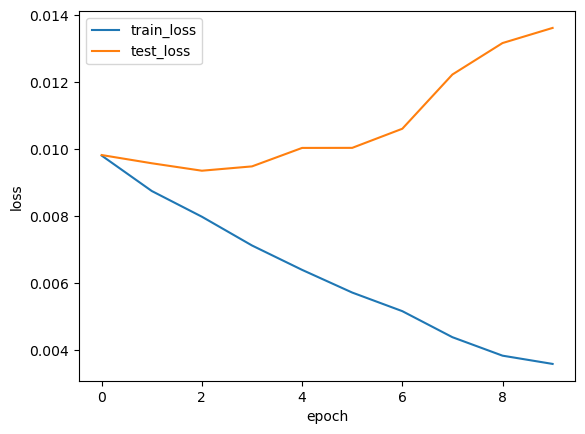

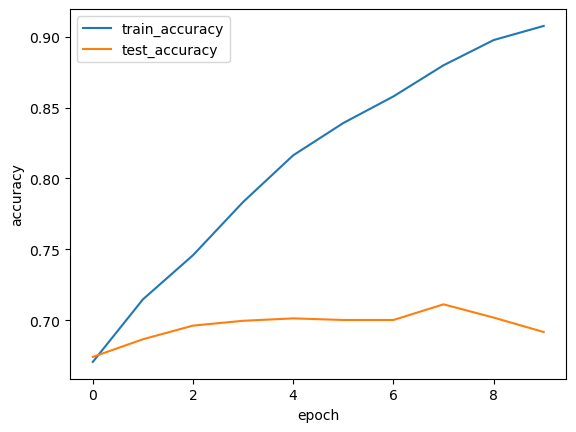

In [25]:
def plot_results(train_loss,test_loss,label_txt='loss'):
    plt.figure()
    plt.plot(range(len(train_loss)), train_loss, label="train_"+label_txt)
    plt.plot(range(len(test_loss)), test_loss, label="test_"+label_txt)
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel(label_txt)
    
plot_results(training_loss,testing_loss)
plot_results(training_acc,testing_acc,label_txt='accuracy')